In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import subprocess

import common

In [2]:
df = common.run_benchmark(
    args="--ray_offset 0.2 --omp_n_threads 16 --p_rays_start 12 --p_rays_end 25 --nbench 32",
    print_output=True)
df

/home/hiti/Workspace/SelectedTopicsCompElectronics/build/src/raytracing --ray_offset 0.2 --omp_n_threads 16 --p_rays_start 12 --p_rays_end 24 --nbench 32
Running benchmark with --ray_offset 0.2 --omp_n_threads 16 --p_rays_start 12 --p_rays_end 24 --nbench 32
0.217: Running OpenVDB benchmark for 4096 Rays
0.219: OpenVDB Finished in 0.0014996s (2731.4 kRays/s)
0.223: NanoVDB on CPU Finished in 0.00258995s (1581.5 kRays/s)
0.231: NanoVDB on GPU Finished in 0.000625066s (6.55291 MRays/s)
0.231: Done

0.231: Running OpenVDB benchmark for 5184 Rays
0.233: OpenVDB Finished in 0.00230336s (2250.62 kRays/s)
0.234: NanoVDB on CPU Finished in 0.000474372s (10928.1 kRays/s)
0.238: NanoVDB on GPU Finished in 0.000748518s (6.92569 MRays/s)
0.238: Done

0.238: Running OpenVDB benchmark for 6724 Rays
0.240: OpenVDB Finished in 0.00139951s (4804.53 kRays/s)
0.241: NanoVDB on CPU Finished in 0.000569531s (11806.2 kRays/s)
0.244: NanoVDB on GPU Finished in 0.00087759s (7.66189 MRays/s)
0.244: Done

0.244

time      MRps  kRps/Eur  n_blocks  n_threads
n_rays   kernel                                                        
4096     NanoVDB_CPU  0.002590   1.58150   3.95374       1.0        1.0
         NanoVDB_GPU  0.000625   6.55291  16.38230     256.0      256.0
         OpenVDB      0.001500   2.73140   6.82849       1.0        1.0
5184     NanoVDB_CPU  0.000474  10.92810  27.32030       1.0        1.0
         NanoVDB_GPU  0.000749   6.92569  17.31420     256.0      256.0
...                        ...       ...       ...       ...        ...
9972964  NanoVDB_GPU  0.276506  36.06770  90.16940     256.0      256.0
         OpenVDB      1.099180   9.07310  22.68280       1.0        1.0
12931216 NanoVDB_CPU  0.868046  14.89690  37.24230       1.0        1.0
         NanoVDB_GPU  0.333911  38.72660  96.81640     256.0      256.0
         OpenVDB      1.460400   8.85458  22.13650       1.0        1.0

[96 rows x 5 columns]

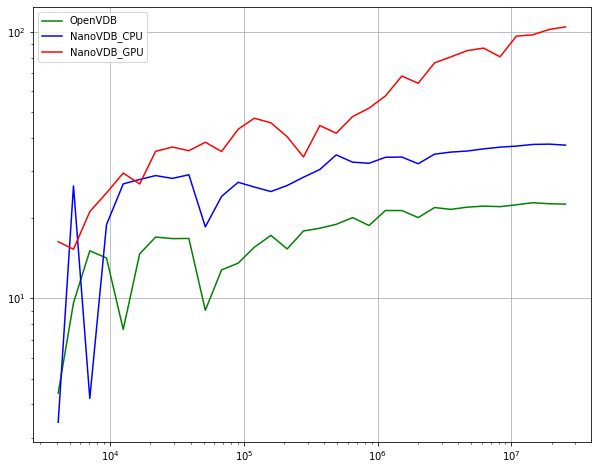

In [71]:
plt.rcParams["figure.figsize"] = (10, 8)

# get a list of all kernels   
kernels=["OpenVDB", "NanoVDB_CPU", "NanoVDB_GPU"]
colors=["green", "blue", "red"]

for i in range(len(kernels)):
    kernel_data = df.xs(kernels[i], level=1,  drop_level=False).reset_index()
    plt.plot(kernel_data["n_rays"], kernel_data["kRps/Eur"], color=colors[i])


plt.legend(kernels)
plt.yscale("log")
plt.xscale("log")
plt.grid()

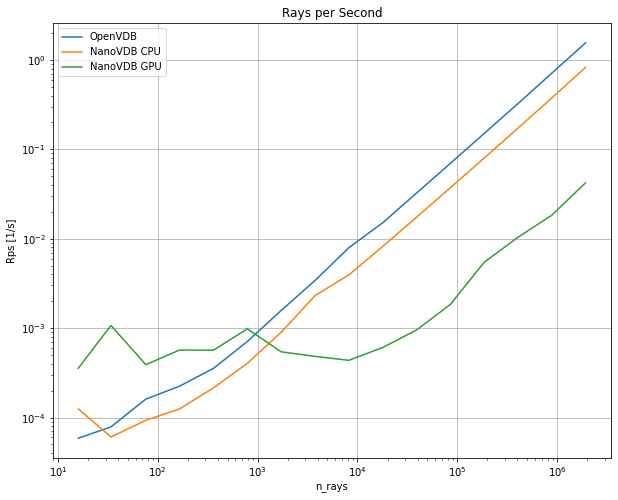

In [4]:
plt.rcParams["figure.figsize"] = (10, 8)

cols = ["rps_ovdb", "rps_nvdb_cpu", "rps_nvdb_gpu"]
cols_names = ["OpenVDB", "NanoVDB CPU", "NanoVDB GPU"]


df.plot()
plt.legend()
plt.grid()
plt.legend(cols_names)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Rps [1/s]")
plt.title("Rays per Second")
plt.show()

Text(0.5, 1.0, 'Relative Speed-Up for 1923096 rays (OpenVDB=1)')

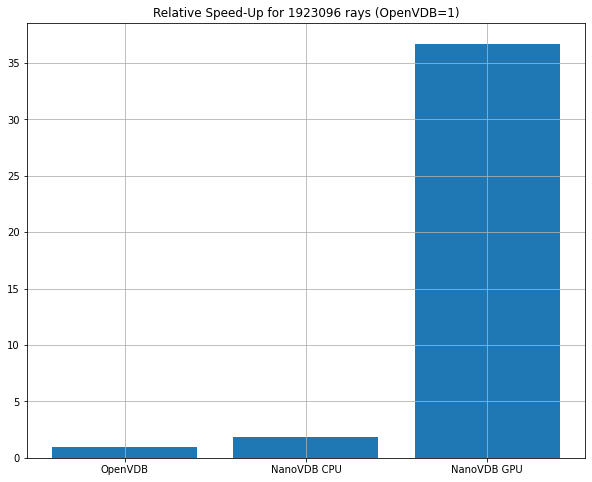

In [5]:
series = df_rps.iloc[-1]
series = series * 1/ series.nsmallest(1)[0]
n_rays = df_rps.index[-1]

plt.bar(cols_names, series.values)
plt.grid()
plt.title(f"Relative Speed-Up for {n_rays} rays (OpenVDB=1)")